In [16]:
from inspect_ai.log import read_eval_log, EvalLog
import matplotlib.pyplot as plt
import numpy as np

In [46]:
#log_file_path = "../logs/2025-07-07T13-31-06+01-00_directors-task_azDPMYY6YBNKU7H6iPeL4J.eval"
log_file_path = "../logs/2025-07-18T15-47-48+01-00_directors-task_KkqPyaQHdTJq2VxZtn4UPo.eval"
log = read_eval_log(log_file_path)
print(f"number of samples in log: {len(log.samples)}")

number of samples in log: 2000


In [18]:

#from inspect_ai import score
#from director_task.grouped_metrics import create_comprehensive_metrics, grouped_accuracy_scorer

#metrics = create_comprehensive_metrics()
#scorer = grouped_accuracy_scorer()
#new_log = score(log, scorer)


In [19]:
#from inspect_ai.log import write_eval_log


#write_eval_log(new_log, "../logs/rescored_directors_task.eval")

Text(0.5, 1.0, 'Accuracy by sample type')

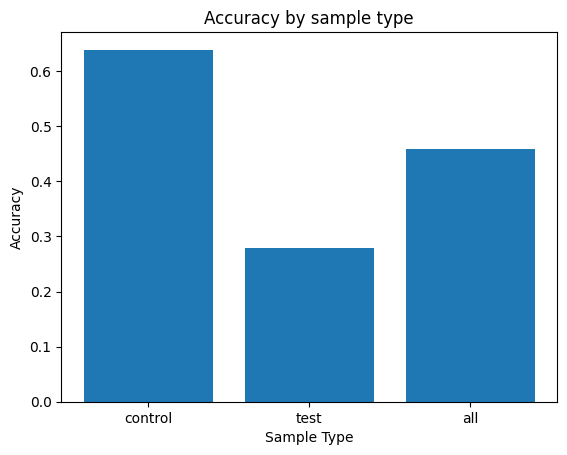

In [47]:
#print(log.results.scores[0].metrics["control"])
#for key, value in log.results.scores[0].metrics.items():
#    print(f"key {key}, value: {value.value}")
sample_type_results = [metric.value for metric in log.results.scores[0].metrics.values() if metric.params["group_key"]=="sample_type"]
sample_type_keys = [metric.name for metric in log.results.scores[0].metrics.values() if metric.params["group_key"]=="sample_type"]
plt.bar(sample_type_keys, sample_type_results)
plt.xlabel('Sample Type')
plt.ylabel('Accuracy')
plt.title('Accuracy by sample type')

Text(0.5, 1.0, 'Accuracy by selection rule')

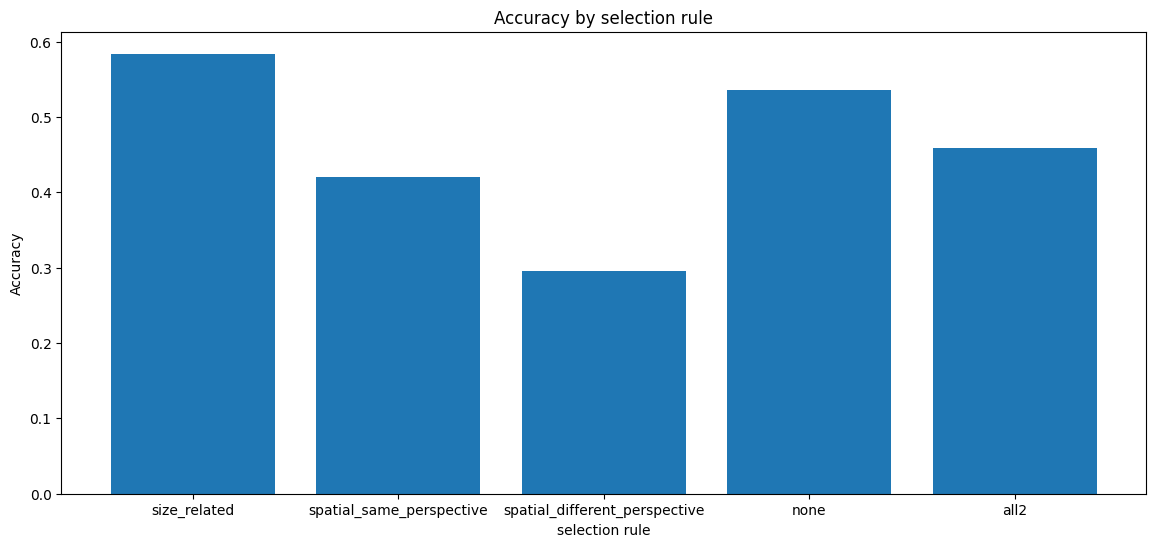

In [48]:
selection_rule_results = [metric.value for metric in log.results.scores[0].metrics.values() if metric.params["group_key"]=="selection_rule_type"]
selection_rule_keys = [metric.name for metric in log.results.scores[0].metrics.values() if metric.params["group_key"]=="selection_rule_type"]
plt.figure(figsize=(14, 6))
plt.bar(selection_rule_keys, selection_rule_results)
plt.xlabel('selection rule')
plt.ylabel('Accuracy')
plt.title('Accuracy by selection rule')

In [44]:
# now graph the different selection_rules split by test and control
control_samples = {}
test_samples = {}

for sample in log.samples:
    if sample.metadata["sample_type"] == "control":
        selection_rule = sample.metadata["selection_rule_type"]
        if selection_rule not in control_samples.keys():
            control_samples[selection_rule] = []
        control_samples[selection_rule].append(sample)
    else:
        selection_rule = sample.metadata["selection_rule_type"]
        if selection_rule not in test_samples.keys():
            test_samples[selection_rule] = []
        test_samples[selection_rule].append(sample)

control_averages = {}
test_averages = {}

for selection_rule in control_samples.keys():
    num_samples = len(control_samples[selection_rule])
    num_correct = 0
    for sample in control_samples[selection_rule]:
        if sample.score.value == "C":
            num_correct += 1
    control_averages[selection_rule] = num_correct/num_samples

for selection_rule in test_samples.keys():
    num_samples = len(test_samples[selection_rule])
    num_correct = 0
    for sample in test_samples[selection_rule]:
        if sample.score.value == "C":
            num_correct += 1
    test_averages[selection_rule] = num_correct/num_samples
print(control_averages)
print(test_averages)

{'size_related': 0.852, 'spatial_same_perspective': 0.64, 'spatial_different_perspective': 0.808, 'none': 0.784}
{'size_related': 0.392, 'spatial_same_perspective': 0.212, 'spatial_different_perspective': 0.216, 'none': 0.244}


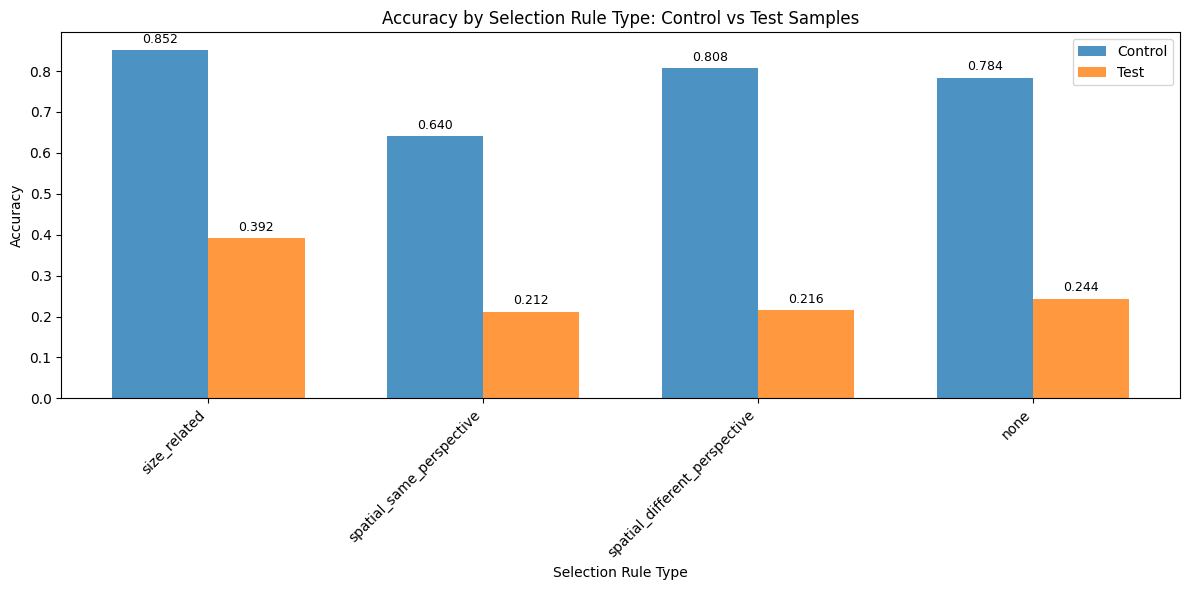

In [49]:
# Create grouped bar chart for control vs test samples by selection rule type
selection_rules = list(control_averages.keys())
control_values = [control_averages[rule] for rule in selection_rules]
test_values = [test_averages[rule] for rule in selection_rules]

x = np.arange(len(selection_rules))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, control_values, width, label='Control', alpha=0.8)
bars2 = ax.bar(x + width/2, test_values, width, label='Test', alpha=0.8)

ax.set_xlabel('Selection Rule Type')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by Selection Rule Type: Control vs Test Samples')
ax.set_xticks(x)
ax.set_xticklabels(selection_rules, rotation=45, ha='right')
ax.legend()

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [22]:
# now graph the results based on the number of alternate items that match the filter criteria
from director_task.grid import Grid
from director_task.item import Item
from director_task.question import Question


samples_by_altrnate_count = [[], [], [], [], [], [], []]

assert log.samples, "No samples found in the log."
for sample in log.samples:
    grid_flattened = sample.metadata["items"]
    grid = Grid(sample.metadata["grid_width"], sample.metadata["grid_height"])
    for item in grid_flattened:
        if item["item"] is not None:
            grid.item_grid[item["position"]["x"]][item["position"]["y"]] = Item(name=item["item"]["name"], image_path=item["item"]["image_path"], boolean_properties=item["item"]["boolean_properties"], scalar_properties=item["item"]["scalar_properties"])
        grid.set_blocked(item["position"]["x"], item["position"]["y"], item["is_blocked"])

    question_no_selection = Question(sample.metadata["question"]["target_type"], sample.metadata["question"]["filter_criteria"], selection_rule=None, is_reversed=sample.metadata["question"]["is_reversed"])
    matching_items = question_no_selection.find_target(grid)
    alternate_count = len(matching_items)-1

    #print(f"Sample {sample.id} has {alternate_count} alternate items matching the filter criteria.")
    #print(f"len samples by alternate count: {len(samples_by_altrnate_count)}")
    samples_by_altrnate_count[alternate_count].append(sample)

# now calculate the accuracy for each 
accuracies_by_alternate_count = []
for alternate_count in range(len(samples_by_altrnate_count)):
    number_of_samples = len(samples_by_altrnate_count[alternate_count])
    num_correct_samples = 0
    #print(f"Alternate count: {alternate_count}, Number of samples: {number_of_samples}")
    for sample in samples_by_altrnate_count[alternate_count]:
        print(f"Sample {sample.id} has score: {sample.score.value}")
        if sample.score.value == "C":
            num_correct_samples += 1
    accuracy = num_correct_samples / len(samples_by_altrnate_count[alternate_count]) if len(samples_by_altrnate_count[alternate_count])>0 else -0.1
    accuracies_by_alternate_count.append(accuracy)

Sample 0 has score: C
Sample 1 has score: C
Sample 2 has score: C
Sample 3 has score: C
Sample 4 has score: I
Sample 5 has score: C
Sample 6 has score: I
Sample 7 has score: C
Sample 9 has score: C
Sample 10 has score: C
Sample 11 has score: C
Sample 13 has score: C
Sample 14 has score: C
Sample 15 has score: I
Sample 16 has score: C
Sample 17 has score: C
Sample 18 has score: I
Sample 19 has score: I
Sample 20 has score: C
Sample 21 has score: C
Sample 22 has score: C
Sample 23 has score: I
Sample 24 has score: C
Sample 25 has score: C
Sample 26 has score: C
Sample 27 has score: C
Sample 28 has score: C
Sample 29 has score: C
Sample 30 has score: C
Sample 31 has score: C
Sample 32 has score: C
Sample 33 has score: C
Sample 34 has score: C
Sample 35 has score: C
Sample 36 has score: C
Sample 37 has score: C
Sample 38 has score: C
Sample 39 has score: C
Sample 40 has score: C
Sample 41 has score: C
Sample 42 has score: C
Sample 43 has score: C
Sample 44 has score: C
Sample 46 has score:

Text(0.5, 1.0, 'Accuracy by alternate item count')

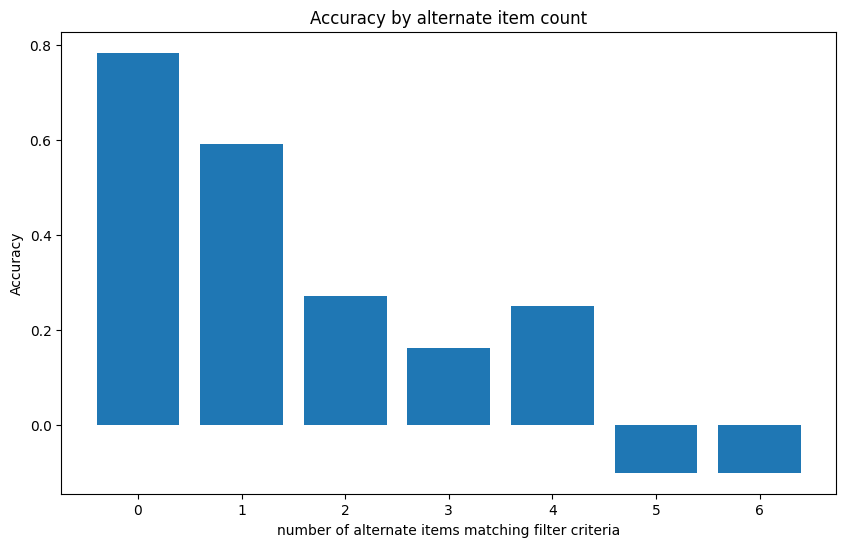

In [50]:

plt.figure(figsize=(10, 6))
plt.bar(range(len(accuracies_by_alternate_count)), accuracies_by_alternate_count)
plt.xlabel('number of alternate items matching filter criteria')
plt.ylabel('Accuracy')
plt.title('Accuracy by alternate item count')

Text(0.5, 1.0, 'Difference between number of times an answer was given and the number of times it was the target')

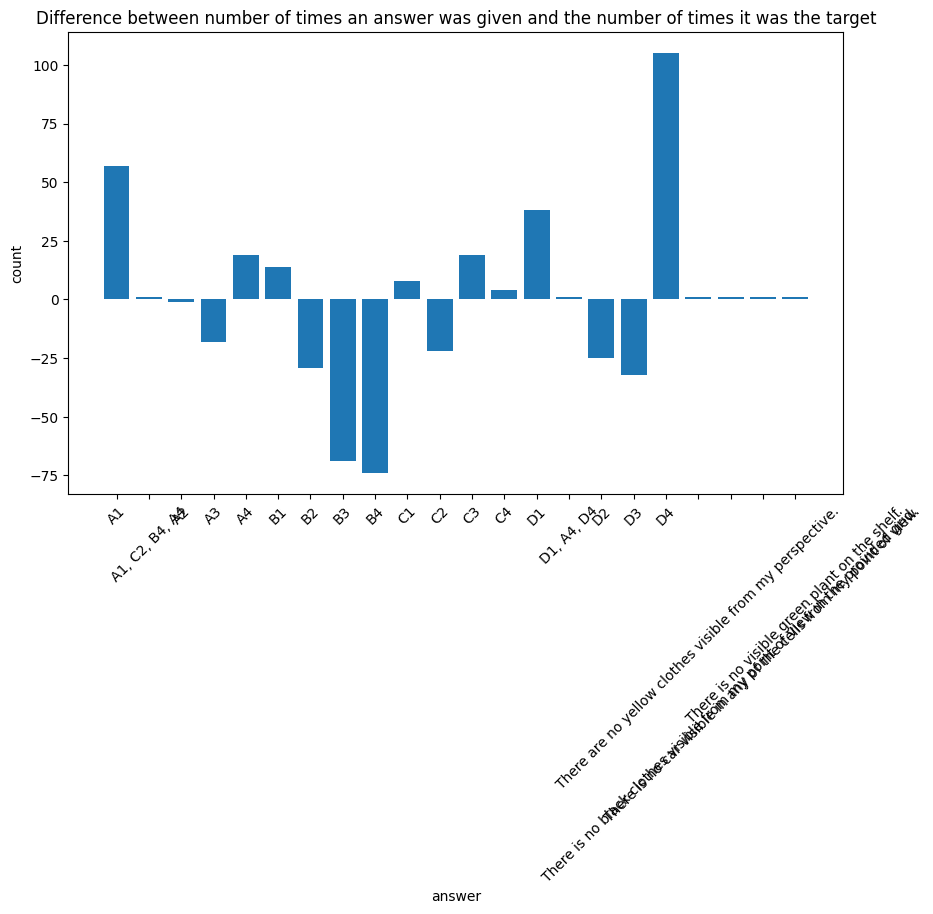

In [51]:
# graph the number of samples with each given answer 
answer_counts = {}
target_counts = {}
for sample in log.samples:
    answer = sample.output.message.content.strip()
    target = sample.target
    if answer not in answer_counts:
        answer_counts[answer] = 0
    if target not in target_counts:
        target_counts[target] = 0
    answer_counts[answer] += 1
    target_counts[target] += 1

answer_counts = dict(sorted(answer_counts.items(), key=lambda item: item[0], reverse=False))
for key in answer_counts.keys():
    answer_counts[key] -= target_counts.get(key, 0)
    
plt.figure(figsize=(10, 6))
plt.bar(range(len(answer_counts)), answer_counts.values())
plt.xticks(range(len(answer_counts)), answer_counts.keys(), rotation=45)
plt.xlabel('answer')
plt.ylabel('count')
plt.title('Difference between number of times an answer was given and the number of times it was the target')

In [25]:
fill_ratio_log_path = "../logs/2025-07-07T16-56-56+01-00_directors-task_AoE4w8sLXAoPk3xeu4ydcg.eval"
fill_ratio_log = read_eval_log(fill_ratio_log_path)
print(f"number of samples in log: {len(fill_ratio_log.samples)}")

number of samples in log: 200


Sample 0 has score: I
Sample 1 has score: I
Sample 2 has score: C
Sample 3 has score: I
Sample 4 has score: C
Sample 5 has score: C
Sample 6 has score: I
Sample 7 has score: C
Sample 8 has score: C
Sample 9 has score: I
Sample 10 has score: I
Sample 11 has score: I
Sample 12 has score: I
Sample 13 has score: I
Sample 14 has score: C
Sample 15 has score: I
Sample 16 has score: I
Sample 17 has score: I
Sample 18 has score: I
Sample 19 has score: I
Sample 20 has score: I
Sample 21 has score: C
Sample 22 has score: C
Sample 23 has score: C
Sample 24 has score: C
Sample 25 has score: C
Sample 26 has score: C
Sample 27 has score: I
Sample 28 has score: C
Sample 29 has score: C
Sample 30 has score: C
Sample 31 has score: C
Sample 32 has score: I
Sample 33 has score: C
Sample 34 has score: C
Sample 35 has score: C
Sample 36 has score: I
Sample 37 has score: C
Sample 38 has score: C
Sample 39 has score: C
Sample 40 has score: C
Sample 41 has score: C
Sample 42 has score: C
Sample 43 has score: 

Text(0.5, 1.0, 'Accuracy by item count')

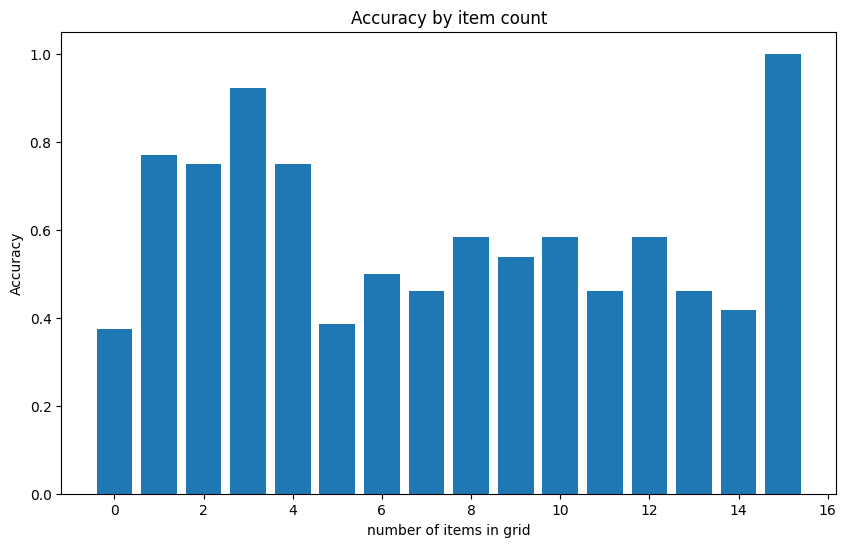

In [26]:
item_count_to_samples = {}
for sample in fill_ratio_log.samples:
    item_count = -1
    for item in sample.metadata["items"]:
        if item["item"] is not None:
            item_count += 1
    if item_count not in item_count_to_samples:
        item_count_to_samples[item_count] = []
    item_count_to_samples[item_count].append(sample)

# now calculate the accuracy for each item count
accuracies_by_item_count = []
for item_count in range(16):
    number_of_samples = len(item_count_to_samples[item_count]) if item_count in item_count_to_samples else 0
    num_correct_samples = 0
    #print(f"Item count: {item_count}, Number of samples: {number_of_samples}")
    for sample in item_count_to_samples.get(item_count, []):
        print(f"Sample {sample.id} has score: {sample.score.value}")
        if sample.score.value == "C":
            num_correct_samples += 1
    accuracy = num_correct_samples / number_of_samples if number_of_samples > 0 else -0.1
    accuracies_by_item_count.append(accuracy)

plt.figure(figsize=(10, 6))
plt.bar(range(len(accuracies_by_item_count)), accuracies_by_item_count)
plt.xlabel('number of items in grid')
plt.ylabel('Accuracy')
plt.title('Accuracy by item count')

In [27]:
# check if a file has any samples with tool calls to crop or rotate.
tool_log_path = "../logs/2025-07-18T14-33-57+01-00_directors-task_Gn7op5tjY2w5Tdz2F9o8pp.eval"
tool_log = read_eval_log(tool_log_path)
print(f"number of samples in log: {len(tool_log.samples)}")

number of samples in log: 200


In [28]:
from inspect_ai.model import ChatMessageAssistant
from inspect_ai.tool import ToolResult


samples_with_tool_calls = []
for sample in tool_log.samples:
    for message in sample.messages:
        if isinstance(message, ChatMessageAssistant):

            if message.tool_calls is not None:
                for tool_call in message.tool_calls:
                    if tool_call.function == "crop_image" or tool_call.function == "rotate_image":
                        samples_with_tool_calls.append(sample)
                        print(sample.id)
                        break

print(len(samples_with_tool_calls))


108
1
